In [52]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from IPython.display import display, HTML

#HTML(df.to_html())
#display(df)

hpi_red = '#b00639'
hpi_blue = '#007a9e'

def get_column_names(benchmark): 
    table_info = json.load(open(benchmark + '_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    return pd.read_csv(benchmark + '_results.csv', header=None, names=get_column_names(benchmark))

# Columns: sample_size, distinct_values, variance, remainder_size, value, actual_count, filter_count

def percent(x, pos):
    'The two args are the value and tick position'
    return ('%i' % (x * 100)) + "%"

def select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size):
    return data[(data.value_count == value_count) &
                (data.distinct_values == distinct_values) &
                (data.data == data_distribution) & 
                (data.remainder_size == remainder_size) &
                (data.quotient_size == quotient_size)]

def get_mean_squared_error(errors, probabilities):
    mse = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        mse += probability * error * error
        
    return mse

def get_mean_error(errors, probabilities):
    me = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        me += probability * error
        
    return me

def misestimation_evaluation(quotient_size, remainder_size, data_distribution):
    value_count = 100000
    distinct_values = 3000

    #percent_formatter = FuncFormatter(percent)
    #ax.yaxis.set_major_formatter(percent_formatter)
    
    #Prepare the data
    data = get_results("cardinality_misestimation_" + data_distribution)
    selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    sample_size = selection["sample_size"].iloc[0]
    over_estimations = selection["over_estimation"]
    probabilities = selection["occurrences"].apply(lambda x: x / sample_size)
    x_data = range(0, distinct_values)
    y_data = np.zeros(distinct_values)
    for i in range(0, len(over_estimations)):
        y_data[over_estimations.iloc[i]] = probabilities.iloc[i]
    one_off_probability = y_data[1]
    correct_probability = y_data[0]
    mean_error = get_mean_error(over_estimations, probabilities)
    mean_square_error = get_mean_squared_error(over_estimations, probabilities)
    filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
    filter_size_bytes = filter_size_bits / 8
    bits_per_value = filter_size_bits / value_count
    column_size = value_count * 2
    
    # Print some Information
    print("One off error probability: " + str(one_off_probability))
    print("Mean Error: " + str(mean_error))
    print("Mean Squared Error: " + str(mean_square_error))
    print("Correct " + str(correct_probability * 100) + "%" + " of the time")
    print("Filter Size [kB]: " + str(filter_size_bytes / 1000))
    print("Bits per Value: " + str(bits_per_value))
    print("Column Size [kB](uint16_t): "  + str(column_size / 1000))
    
    # Configure the plot
    title = "Overcount probabilites"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_distribution + '\n'\
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    #.apply(lambda x: x * 100)
    plt.plot(x_data[1:100], np.array(y_data[1:100]) * 100, color=hpi_red, label="filter counts")
    plt.ylabel('probability [%]')
    plt.xlabel('overcount')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.yaxis.grid()
    ax.xaxis.grid()
    
    # Save Output
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_") \
                                        .replace(",","_").replace("\n","_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    
    #Render
    plt.show()

def evaluate(quotient_size, remainder_size, data_distribution):
    value_count = 100000
    distinct_values = 3000

    data = get_results("filter_cardinality_estimation_" + data_distribution)
    selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    
    title = "Filter Counts Vs. Actual Counts"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_distribution + '\n' \
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
            
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["value"], selection["filter_count"], color=hpi_red, label="filter counts")
    plt.plot(selection["value"], selection["actual_count"], color=hpi_blue, label="actual counts")
    plt.legend(loc='upper left')
    plt.ylabel('value count')
    plt.xlabel('value')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=distinct_values)
    
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_").replace(",","_").replace("\n","_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    plt.show()
    
def filter_comparison_table(quotient_sizes, remainder_sizes, data_distribution):
    value_count = 100000
    distinct_values = 3000
    
    data = get_results("cardinality_misestimation_" + data_distribution)
    filter_information = []
    
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
                selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
                if len(selection) == 0:
                    continue
                sample_size = selection["sample_size"].iloc[0]
                x_data = selection["over_estimation"]
                y_data = selection["occurrences"].apply(lambda x: x / sample_size)
                filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
                filter_size_bytes = filter_size_bits / 8
                bits_per_value = filter_size_bits / value_count
                mean_error = get_mean_error(x_data, y_data)
                mean_squared_error = get_mean_squared_error(x_data, y_data)
                correct_probability = y_data.iloc[0]
                filter_information.append((quotient_size, remainder_size, bits_per_value, mean_error, mean_squared_error))
    

    columns = ["Quotient Size", "Remainder Size", "Bits per Value", "Mean Error", "Mean Squared Error"]
    df = pd.DataFrame(filter_information, columns=columns)
    #display(df.sort_values(by=["Bits per Value"]))
    display(df)
    

In [53]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
filter_comparison_table(quotient_sizes, remainder_sizes, "normal")

,Quotient Size,Remainder Size,Bits per Value,Mean Error,Mean Squared Error
0,14,4,0.98304,0.377907,21.585953
1,14,8,1.63840,0.020290,1.115670
2,14,16,2.94912,0.000180,0.008387
3,15,2,1.31072,0.737850,41.940170
4,15,4,1.96608,0.191297,10.781263
5,15,8,3.27680,0.014743,0.836243
6,15,16,5.89824,0.000000,0.000000
7,16,2,2.62144,0.392547,22.554480
8,16,4,3.93216,0.093117,5.185483
9,16,8,6.55360,0.004980,0.302027


In [20]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
filter_comparison_table(quotient_sizes, remainder_sizes, "uniform")

,Quotient Size,Remainder Size,Bits per Value,Mean Error,Mean Squared Error
0,14,4,0.98304,0.37026,12.34926
1,14,8,1.63840,0.02552,0.84216
2,14,16,2.94912,0.00000,0.00000
3,15,2,1.31072,0.77264,26.04162
4,15,4,1.96608,0.18348,6.18552
5,15,8,3.27680,0.01386,0.45738
6,15,16,5.89824,0.00000,0.00000
7,16,2,2.62144,0.37620,12.56706
8,16,4,3.93216,0.09504,3.13632
9,16,8,6.55360,0.00638,0.21054


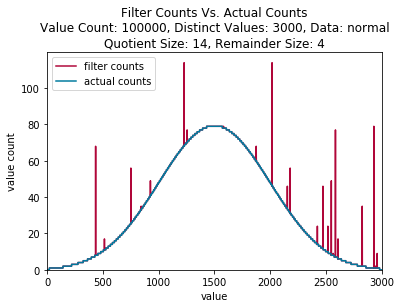

One off error probability: 0.000933333333333
Mean Error: 0.377906666667
Mean Squared Error: 21.5859533333
Correct 98.8846666667% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


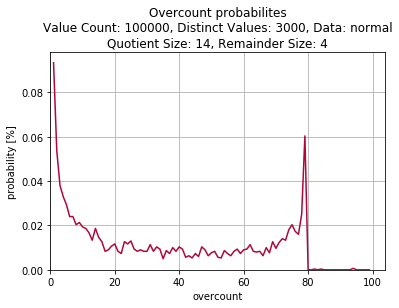

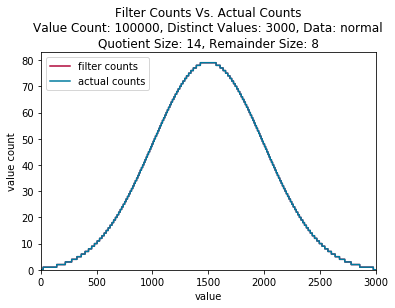

One off error probability: 5.33333333333e-05
Mean Error: 0.02029
Mean Squared Error: 1.11567
Correct 99.933% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


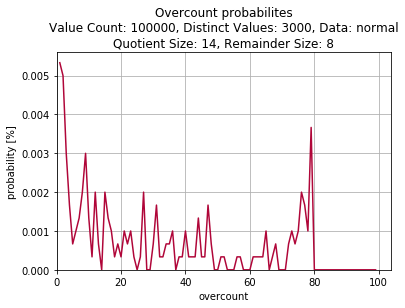

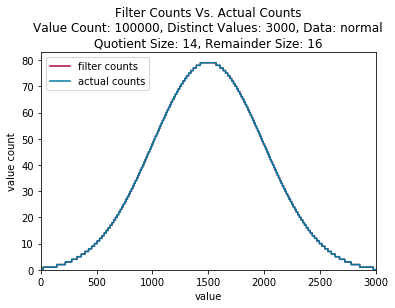

One off error probability: 0.0
Mean Error: 0.00018
Mean Squared Error: 0.00838666666667
Correct 99.9993333333% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


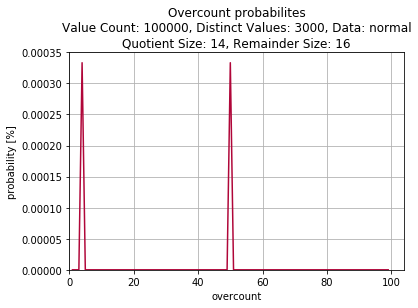

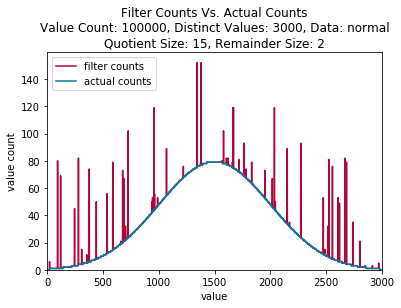

One off error probability: 0.00173666666667
Mean Error: 0.73785
Mean Squared Error: 41.94017
Correct 97.7963333333% of the time
Filter Size [kB]: 16.384
Bits per Value: 1.31072
Column Size [kB](uint16_t): 200.0


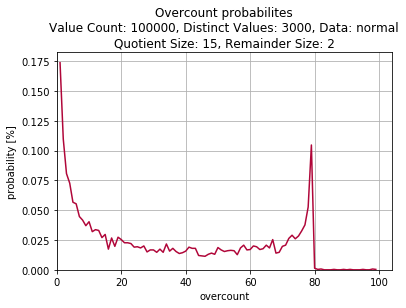

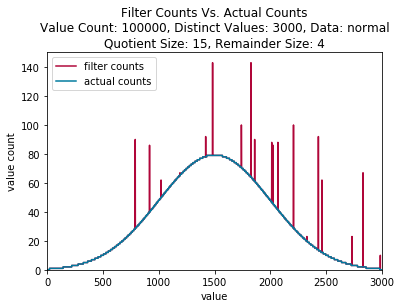

One off error probability: 0.000476666666667
Mean Error: 0.191296666667
Mean Squared Error: 10.7812633333
Correct 99.4216666667% of the time
Filter Size [kB]: 24.576
Bits per Value: 1.96608
Column Size [kB](uint16_t): 200.0


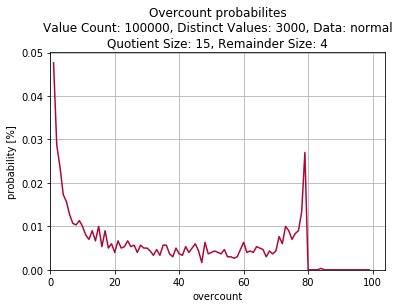

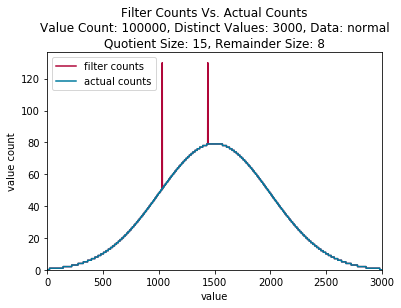

One off error probability: 3e-05
Mean Error: 0.0147433333333
Mean Squared Error: 0.836243333333
Correct 99.9556666667% of the time
Filter Size [kB]: 40.96
Bits per Value: 3.2768
Column Size [kB](uint16_t): 200.0


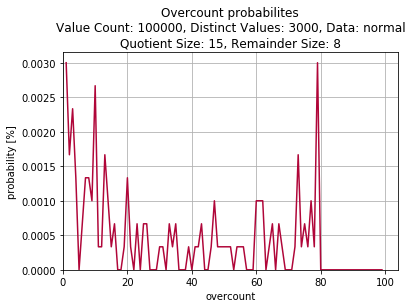

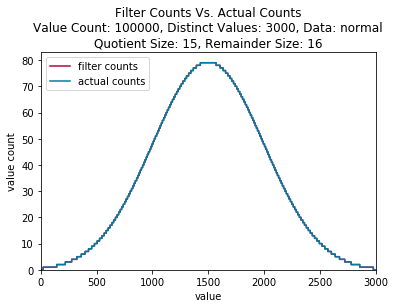

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 73.728
Bits per Value: 5.89824
Column Size [kB](uint16_t): 200.0


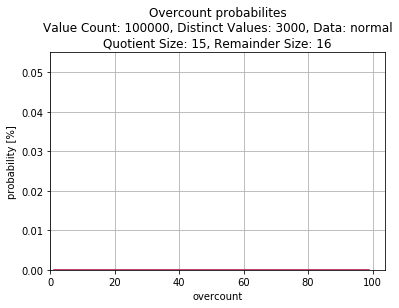

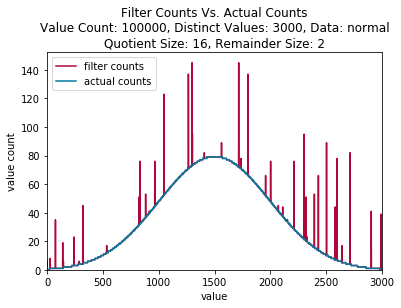

One off error probability: 0.000836666666667
Mean Error: 0.392546666667
Mean Squared Error: 22.55448
Correct 98.852% of the time
Filter Size [kB]: 32.768
Bits per Value: 2.62144
Column Size [kB](uint16_t): 200.0


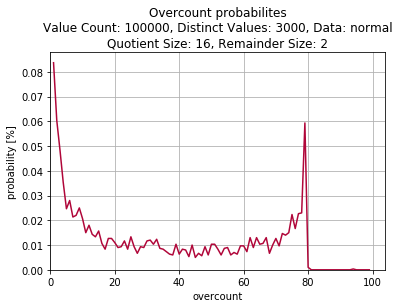

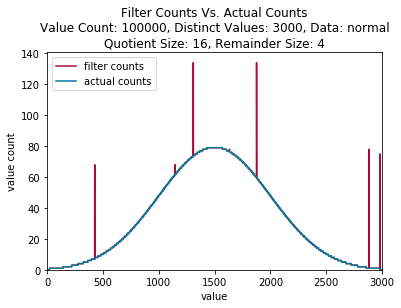

One off error probability: 0.00023
Mean Error: 0.0931166666667
Mean Squared Error: 5.18548333333
Correct 99.713% of the time
Filter Size [kB]: 49.152
Bits per Value: 3.93216
Column Size [kB](uint16_t): 200.0


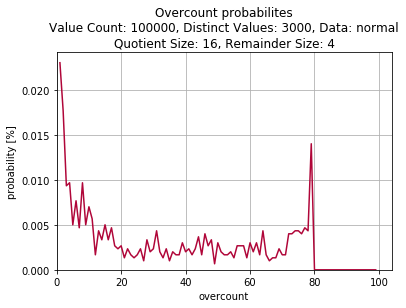

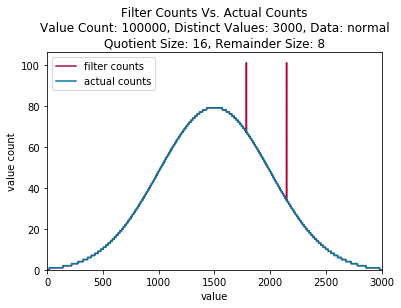

One off error probability: 6.66666666667e-06
Mean Error: 0.00498
Mean Squared Error: 0.302026666667
Correct 99.9876666667% of the time
Filter Size [kB]: 81.92
Bits per Value: 6.5536
Column Size [kB](uint16_t): 200.0


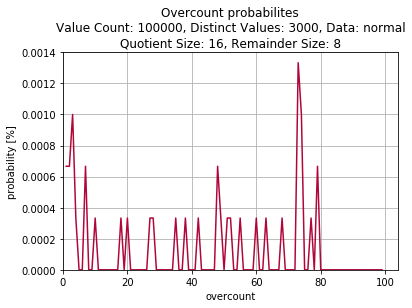

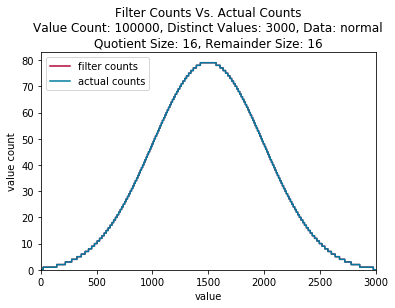

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 147.456
Bits per Value: 11.79648
Column Size [kB](uint16_t): 200.0


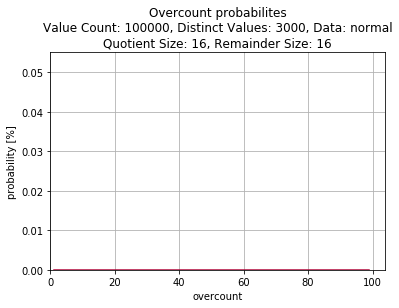

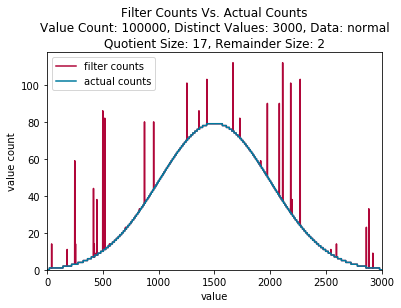

One off error probability: 0.000436666666667
Mean Error: 0.187586666667
Mean Squared Error: 10.6862466667
Correct 99.4456666667% of the time
Filter Size [kB]: 65.536
Bits per Value: 5.24288
Column Size [kB](uint16_t): 200.0


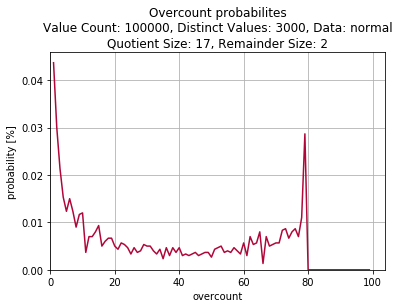

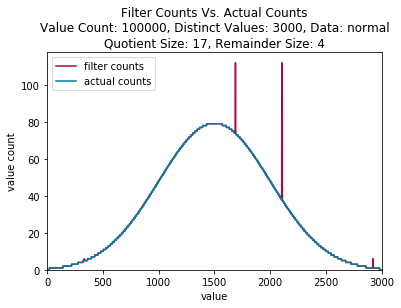

One off error probability: 0.000123333333333
Mean Error: 0.0458566666667
Mean Squared Error: 2.61441
Correct 99.8563333333% of the time
Filter Size [kB]: 98.304
Bits per Value: 7.86432
Column Size [kB](uint16_t): 200.0


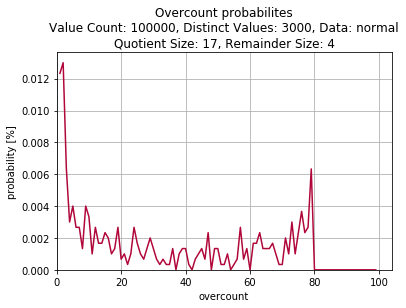

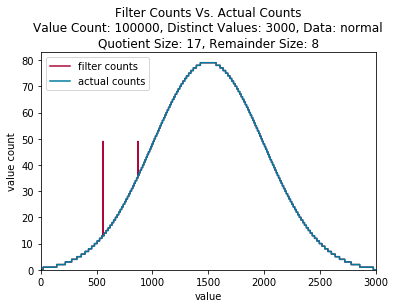

One off error probability: 1.33333333333e-05
Mean Error: 0.00426
Mean Squared Error: 0.24518
Correct 99.9876666667% of the time
Filter Size [kB]: 163.84
Bits per Value: 13.1072
Column Size [kB](uint16_t): 200.0


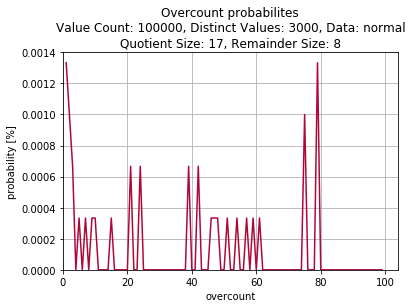

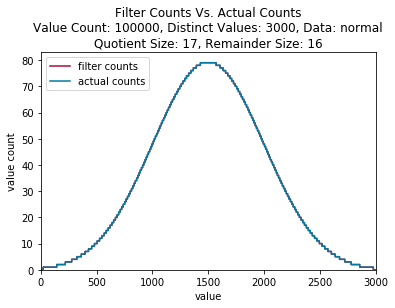

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 294.912
Bits per Value: 23.59296
Column Size [kB](uint16_t): 200.0


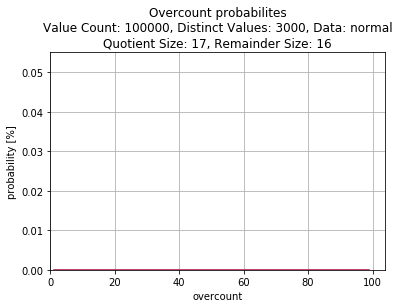

In [57]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14, 15, 16, 17]

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size, "normal")
        misestimation_evaluation(quotient_size, remainder_size, "normal")

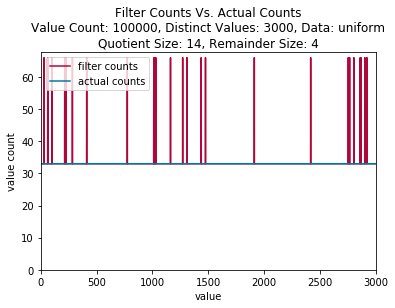

One off error probability: 0.0
Mean Error: 0.37026
Mean Squared Error: 12.34926
Correct 98.884% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


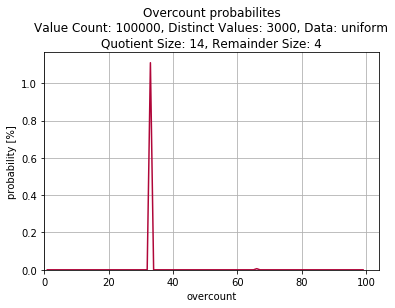

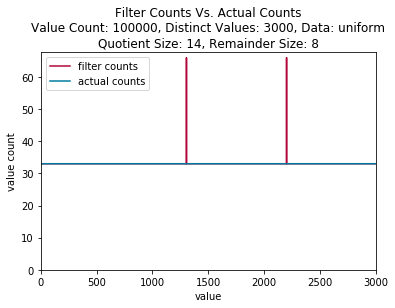

One off error probability: 0.0
Mean Error: 0.02552
Mean Squared Error: 0.84216
Correct 99.9226666667% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


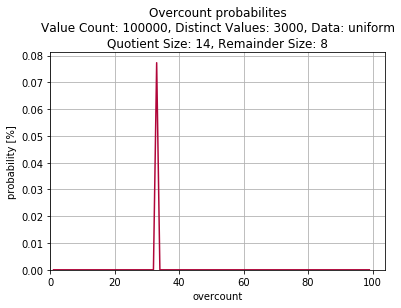

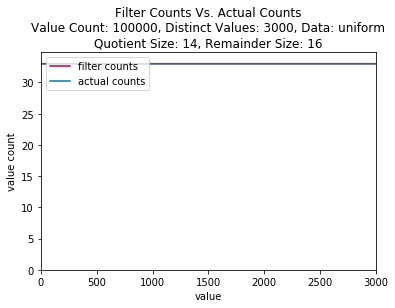

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


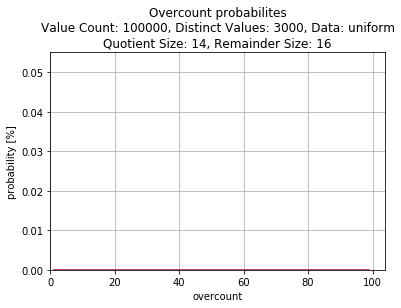

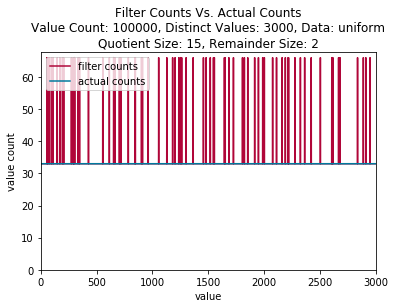

One off error probability: 0.0
Mean Error: 0.77264
Mean Squared Error: 26.04162
Correct 97.6836666667% of the time
Filter Size [kB]: 16.384
Bits per Value: 1.31072
Column Size [kB](uint16_t): 200.0


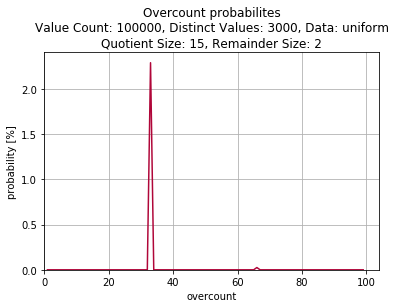

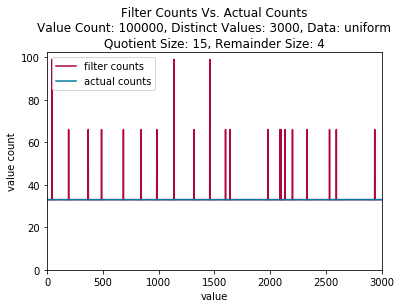

One off error probability: 0.0
Mean Error: 0.18348
Mean Squared Error: 6.18552
Correct 99.45% of the time
Filter Size [kB]: 24.576
Bits per Value: 1.96608
Column Size [kB](uint16_t): 200.0


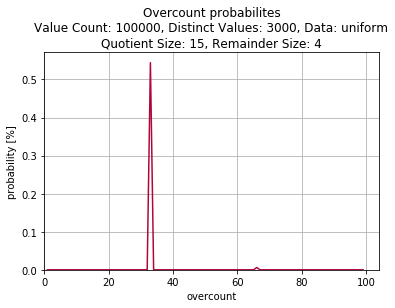

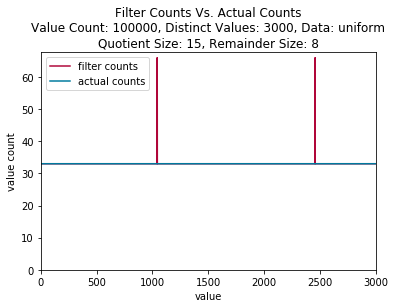

One off error probability: 0.0
Mean Error: 0.01386
Mean Squared Error: 0.45738
Correct 99.958% of the time
Filter Size [kB]: 40.96
Bits per Value: 3.2768
Column Size [kB](uint16_t): 200.0


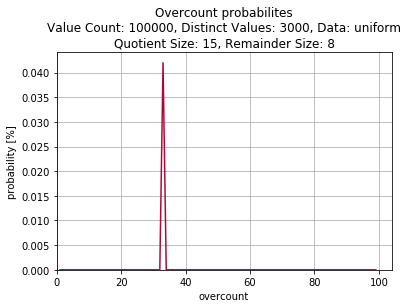

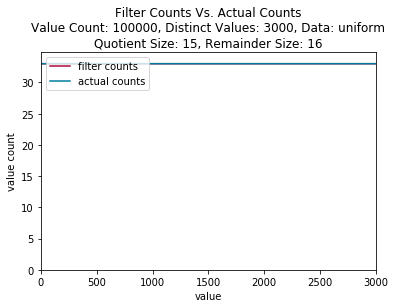

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 73.728
Bits per Value: 5.89824
Column Size [kB](uint16_t): 200.0


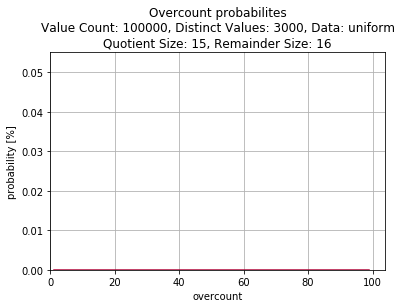

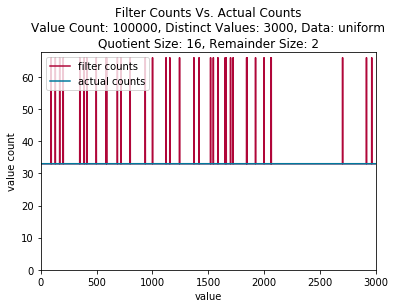

One off error probability: 0.0
Mean Error: 0.3762
Mean Squared Error: 12.56706
Correct 98.867% of the time
Filter Size [kB]: 32.768
Bits per Value: 2.62144
Column Size [kB](uint16_t): 200.0


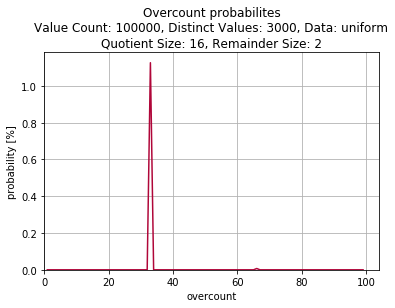

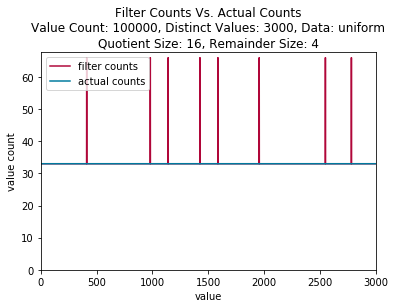

One off error probability: 0.0
Mean Error: 0.09504
Mean Squared Error: 3.13632
Correct 99.712% of the time
Filter Size [kB]: 49.152
Bits per Value: 3.93216
Column Size [kB](uint16_t): 200.0


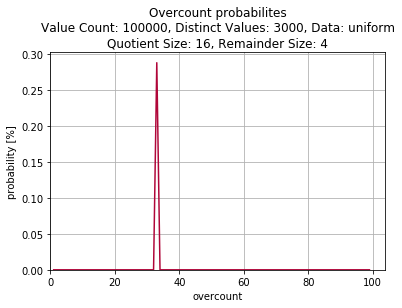

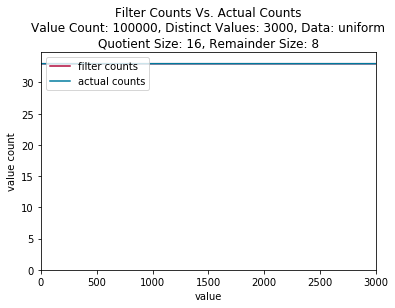

One off error probability: 0.0
Mean Error: 0.00638
Mean Squared Error: 0.21054
Correct 99.9806666667% of the time
Filter Size [kB]: 81.92
Bits per Value: 6.5536
Column Size [kB](uint16_t): 200.0


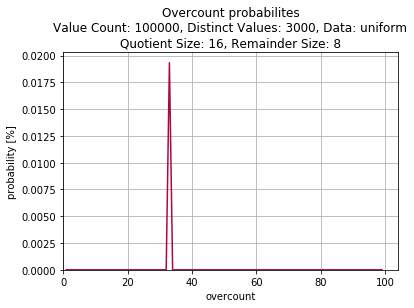

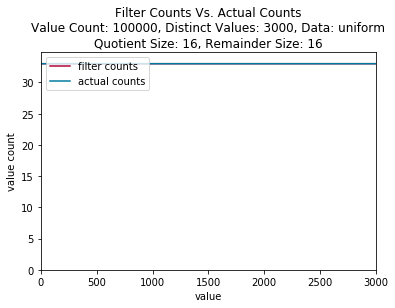

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 147.456
Bits per Value: 11.79648
Column Size [kB](uint16_t): 200.0


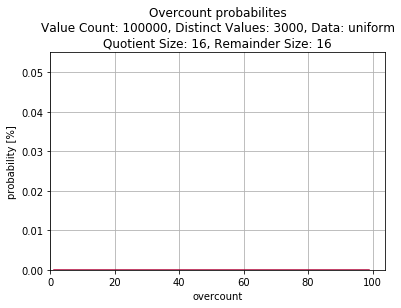

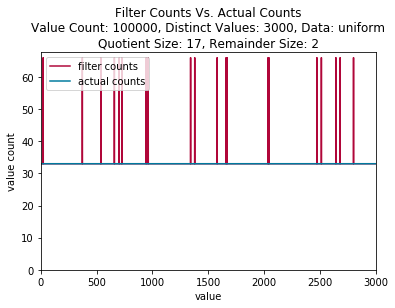

One off error probability: 0.0
Mean Error: 0.1848
Mean Squared Error: 6.12018
Correct 99.441% of the time
Filter Size [kB]: 65.536
Bits per Value: 5.24288
Column Size [kB](uint16_t): 200.0


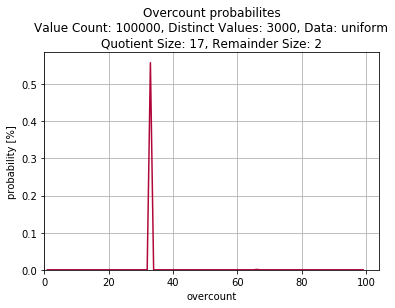

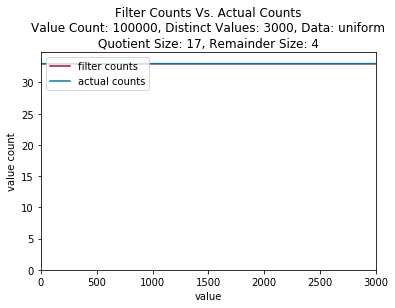

One off error probability: 0.0
Mean Error: 0.0495
Mean Squared Error: 1.6335
Correct 99.85% of the time
Filter Size [kB]: 98.304
Bits per Value: 7.86432
Column Size [kB](uint16_t): 200.0


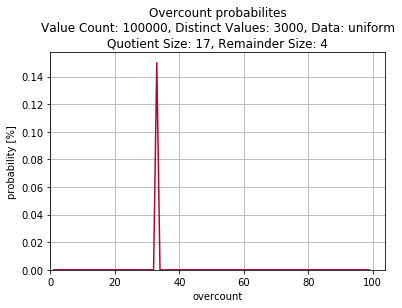

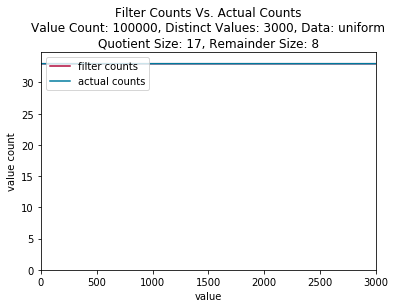

One off error probability: 0.0
Mean Error: 0.0022
Mean Squared Error: 0.0726
Correct 99.9933333333% of the time
Filter Size [kB]: 163.84
Bits per Value: 13.1072
Column Size [kB](uint16_t): 200.0


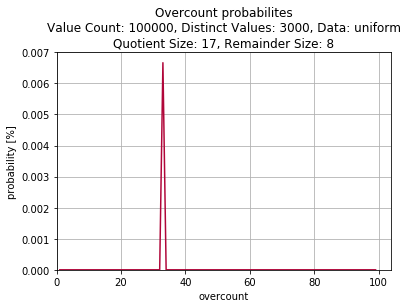

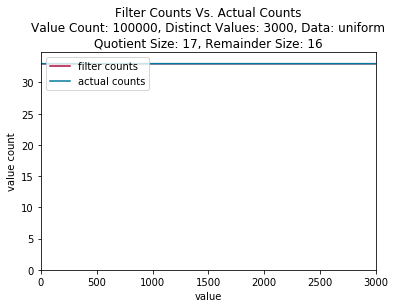

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 294.912
Bits per Value: 23.59296
Column Size [kB](uint16_t): 200.0


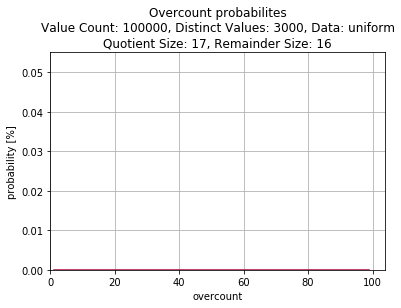

In [56]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14, 15, 16, 17]

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size, "uniform")
        misestimation_evaluation(quotient_size, remainder_size, "uniform")

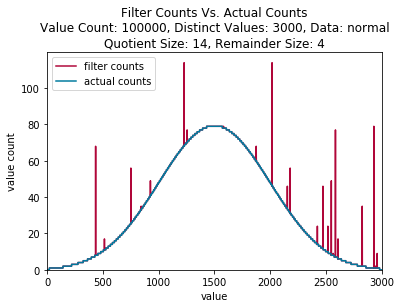

One off error probability: 0.000933333333333
Mean Error: 0.377906666667
Mean Squared Error: 21.5859533333
Correct 98.8846666667% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


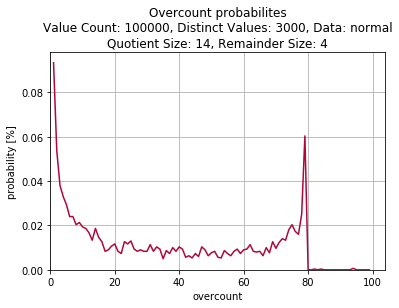

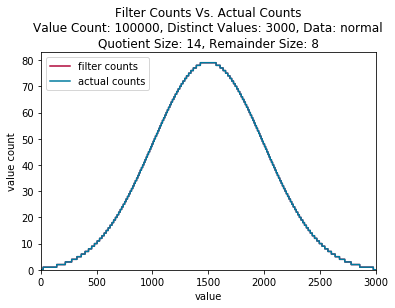

One off error probability: 5.33333333333e-05
Mean Error: 0.02029
Mean Squared Error: 1.11567
Correct 99.933% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


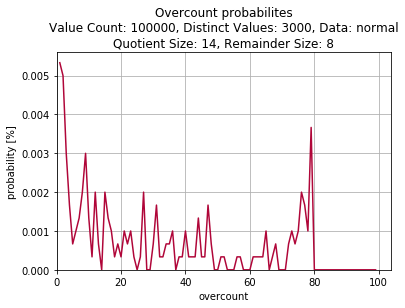

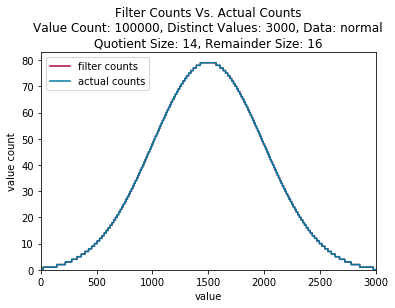

One off error probability: 0.0
Mean Error: 0.00018
Mean Squared Error: 0.00838666666667
Correct 99.9993333333% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


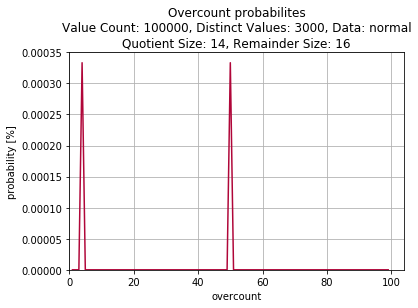

In [55]:
evaluate(14, 4, "normal")
misestimation_evaluation(14, 4, "normal")
evaluate(14, 8, "normal")
misestimation_evaluation(14, 8, "normal")
evaluate(14, 16, "normal")
misestimation_evaluation(14, 16, "normal")

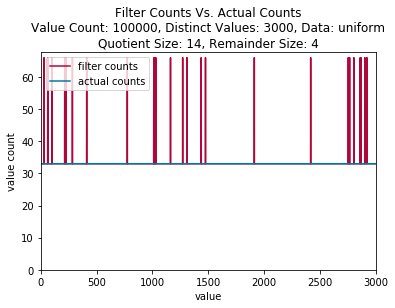

One off error probability: 0.0
Mean Error: 0.37026
Mean Squared Error: 12.34926
Correct 98.884% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


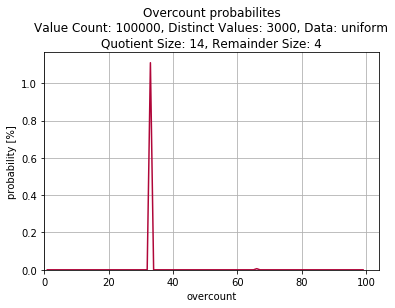

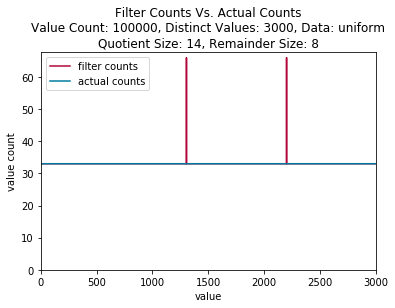

One off error probability: 0.0
Mean Error: 0.02552
Mean Squared Error: 0.84216
Correct 99.9226666667% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


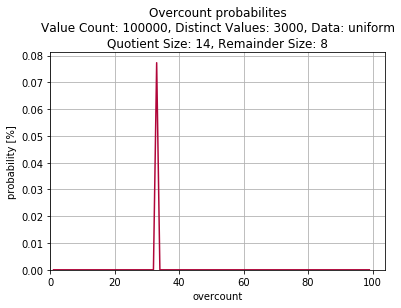

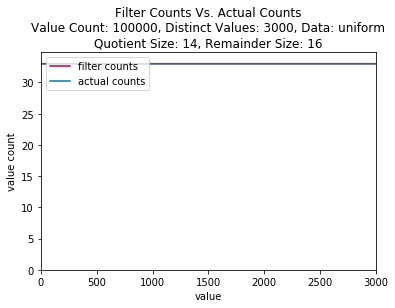

One off error probability: 0.0
Mean Error: 0.0
Mean Squared Error: 0.0
Correct 100.0% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


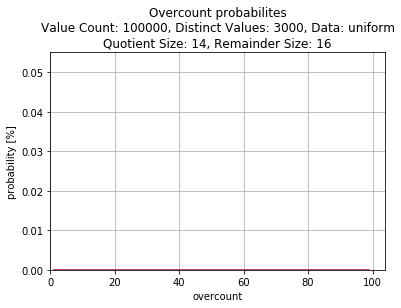

In [58]:
evaluate(14, 4, "uniform")
misestimation_evaluation(14, 4, "uniform")
evaluate(14, 8, "uniform")
misestimation_evaluation(14, 8, "uniform")
evaluate(14, 16, "uniform")
misestimation_evaluation(14, 16, "uniform")